# Введение и как запустить проект

Данный проект - разработка бота для классификации пород собак. В этом ноутбуке находятся эксперименты по использованию различных архитектур сетей. Сам же бот находится в dlschool_project/telegram_bot. Для запуска в файле telegram_token.py нужно указать токен созданого бота. В файле config.py нужно указать путь к папке, в которой находится экспортированная модель. После этого достаточно запустить main.py.

# Разработка модели

https://github.com/154King154/bot_classify - репозиторий проекта

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

# Загрузка датасета



Используемый мной датасет https://www.kaggle.com/jessicali9530/stanford-dogs-dataset/
Его я использовал полностью как train, a для validation собирал картинки в гугле, примерно еще 8500 картинок.
Обучение происходило в колабе, т.к. компьютер чуточку не потянул.

In [9]:
from google.colab import drive
drive.mount('/content/drive/')
#/content/drive/Team Drives/mlearn
#path to files 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from pathlib import Path
#PATH = Path('/home/alex/dogs_dataset/')
PATH = Path('/content/drive/My Drive/dlschool_project/data_dogs')
print(PATH)
tfms = get_transforms(do_flip=True,
                     flip_vert=False,
                     max_rotate=10.0,
                     max_zoom=0.5,
                     max_lighting=0.9,
                     max_warp=0.2)
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=16, size=256)

/content/drive/My Drive/dlschool_project/data_dogs


Проведен серию экспериментов для выявления лучшей совокупности архитекруы сети и accuracy. Веса сохраним в папке /dlschool_project/model/ где каждой используемой в эксперименте архитектуре будет соответсвовать папка с сохраннеными в ней весами.


**Используемые архитектуры:**



*   VGG16 - 55% score
*  ResNeXt - 63% score
* ShuffleNet v2 - 35% score



# VGG16

In [0]:
# если мы создаем предобученную модель, то все слои, кроме последних полносвязных будут заморожены,
# стоит помнить об этом при обучении
model = create_cnn(data, models.vgg16_bn, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:22<00:00, 24221249.85it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


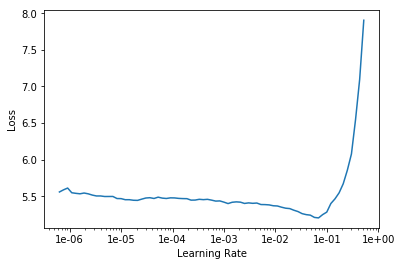

In [0]:
# Здесь мы используем lr_finder, чтобы выбрать скорость обучения
model.lr_find()
model.recorder.plot()

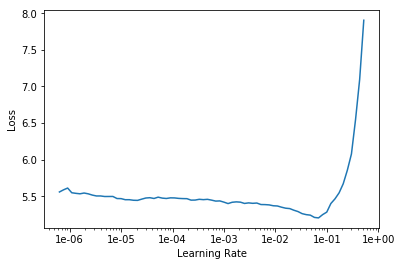

In [0]:
model.recorder.plot()

Как мы видим, эффективно использовать learning rate в пределах 1е-05 до 1е-02.

In [0]:
# используем 1cycle policy подрбнее https://docs.fast.ai/callbacks.one_cycle.html
model.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,4.915517,5.649846,0.013783,1:14:25


In [0]:
# теперь мы хотим разморозить всю модель и продолжить finetuning 
# слои объединены в группы, для каждой группы слоев можно поставить свой learning rate
# чтобы узнать, сколько есть групп, выведем их
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): ReLU(inplace)
   (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): ReLU(inplace)
   (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [0]:
model.unfreeze()
# установим learning rate для каждой из трех групп, делать их отличающимися на порядок
# хорошая идея в большинстве случаев, при этом lr для последнего слоя мы нашли из lr_find
model.fit_one_cycle(1, [1e-4, 1e-3, 1e-2])
model.export()

epoch,train_loss,valid_loss,accuracy,time
0,2.319810,1.910291,0.484066,1:04:54


In [0]:
model.fit_one_cycle(2, [1e-4, 1e-3, 1e-2])

epoch,train_loss,valid_loss,accuracy,time
0,1.800419,1.624959,0.557999,14:58


#resnext50_32x4d

In [10]:
model_resnext = create_cnn(data, torchvision.models.resnext50_32x4d, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


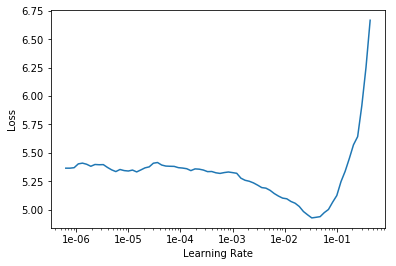

In [13]:
model_resnext.lr_find()
model_resnext.recorder.plot()

In [11]:
model_resnext.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.949468,1.472013,0.598231,1:11:58


In [15]:
model_resnext.unfreeze()
model_resnext.fit_one_cycle(3, [1e-3, 1e-2])
model_resnext.export()

epoch,train_loss,valid_loss,accuracy,time
0,4.873209,11.266698,0.016332,08:17
1,4.884483,11.952904,0.010915,08:14
2,4.754571,5.391190,0.016969,08:15


Как видим, после заморозки слоев обучение идет намного медленнее и accuracy не поднимается выше 0,01. Поэтому, обучение здесь, в отличии от VGG16 будем производить только на последнем слое.

In [16]:
model_resnext = create_cnn(data, torchvision.models.resnext50_32x4d, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [17]:
model_resnext.fit_one_cycle(3, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.110857,2.643168,0.320746,07:33
1,2.147505,1.780908,0.561982,07:34
2,1.577145,1.724624,0.633047,07:33


In [0]:
model_resnext.export()

#shufflenet_v2

In [20]:
model_shuffЫlenet = create_cnn(data, torchvision.models.shufflenet_v2_x1_0, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 9218294/9218294 [00:00<00:00, 38013722.54it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


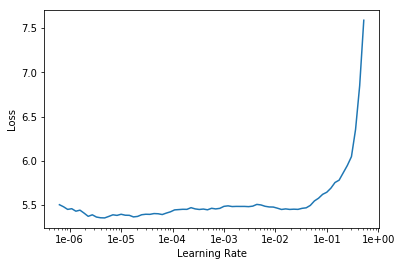

In [21]:
model_shufflenet.lr_find()
model_shufflenet.recorder.plot()

In [22]:
model_shufflenet.fit_one_cycle(3, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.900967,4.812825,0.011871,06:03
1,4.823128,4.752067,0.015137,06:02
2,4.734108,4.690775,0.017607,05:57


In [23]:
model_resnext.unfreeze()
model_resnext.fit_one_cycle(3, [1e-3, 1e-2])

epoch,train_loss,valid_loss,accuracy,time
0,4.682427,84.443398,0.034736,08:13
1,3.388238,20.524326,0.201880,08:18
2,2.733845,35.983433,0.314213,08:13


In [0]:
model_resnext.export()

#googlenet


In [26]:
model_googlenet = create_cnn(data, torchvision.models.googlenet, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 52147035/52147035 [00:01<00:00, 44549432.50it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


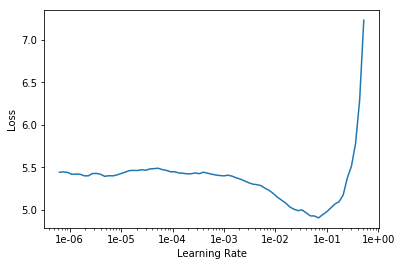

In [27]:
model_googlenet.lr_find()
model_googlenet.recorder.plot()

In [28]:
model_googlenet.fit_one_cycle(3, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,2.057178,1.741865,0.544057,06:35
1,1.701492,1.318141,0.636472,06:32
2,1.202761,1.166526,0.683875,06:32


In [0]:
model_googlenet.export()

In [30]:
model_googlenet.unfreeze()
model_googlenet.fit_one_cycle(3, [1e-03, 1e-02])

epoch,train_loss,valid_loss,accuracy,time
0,3.353034,3.984205,0.148502,06:42
1,2.370401,1.995113,0.466619,06:42
2,1.615225,1.496693,0.599506,06:44


Здесь при разморозке слоев примерно равный score с тем, что получается при обучении только на последнем слое. Но, все же при обучении только на последнем слое он чуть выше. Да и в принципе здесь самый высокий score среди всех архитектур. 

При работе бота я использовал именно эту модель, но на самом деле при реальных тестах на своем карликовом пинчере и той-терьере, resnext определил точно породу, в отличии от этой модели. Поэтому в дальнейшем использовал я именно resnext.